# Natural Language Processing with Machine Learning Classifiers for Adverse Drug Effects

### Set up the environment: 

In [4]:
import root_config as rc

rc.configure()

import pandas as pd
import numpy as np
import sys

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#Display maximum
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

### **Data source:** "ADE corpus"




"ADE corpus": annotated corpus freely available online by the works of Gurulingappa (2012). The corpus download link provided in the paper is now outdated, i.e. a dead link, so through [web archive](https://archive.org/web/) the corpus for download was obtained and validity checked against metrics given in published work. It is provided in the /data/nlp_model_training folder of this project.
The corpus was created from annotating 3000 MEDLINE case reports for mentions of drugs, adverse effects, dosages, and the relationships between them. The annotations were created by 3 individuals.
The corpus is spread into 3 files, DRUG-AE.rel and DRUG-DOSE.rel and ADE-NEG.txt.
DRUG-AE.rel provides relations between drugs and adverse effects and has rows as:

- Column-1: PubMed-ID

- Column-2: Sentence

- Column-3: Dose

- Column-4: Begin offset of Dose at 'document level'

- Column-5: End offset of Dose at 'document level'

- Column-6: Drug

- Column-7: Begin offset of Drug at 'document level'

- Column-8: End offset of Drug at 'document level'
delimited by a pipe delimiter.

DRUG-DOSE.rel provides relations between drugs and dosages.
ADE-NEG.txt provides all sentences in the ADE corpus that DO NOT contain any drug-related adverse effects and is of format:

- PubMed-ID\sNEG\sSentence

where 'NEG' is a fixed string.

There are 6821 lines in DRUG-AE, i.e. 6821 annotations, but 4272 sentences. This is because some sentences have more than one relation mentioned. These sentences will be treated as positive for ADE labelled sentences.
The sentences with drug-dosage relationships (i.e. 213 sentences) constitute a subset of 4272 sentences that contain drug-adverse effect relationships. There are 16695 sentences (and lines) in ADE-NEG and these will be treated as negative for ADE labelled sentences.

Preprocessing is needed to reduce to unique sentences in DRUG-AE.rel, equalize the number of positive and negative labelled sentences, as well as to unify them into one dataframe and split into train and test.

### Preprocessing: reduce to unique sentences in DRUG-AE.rel:

In [5]:
drugAE_path = r'../data/nlp_model_training/DRUG-AE.rel' 
drugAE = pd.read_csv(drugAE_path, sep="|", names=['PubMed-ID',\
                                                 'Sentence',\
                                                 'Adverse-Effect',\
                                                 'Begin Adverse-Effect offset',\
                                                 'End Adverse-Effect offset',\
                                                 'Drug',\
                                                 'Begin Drug offset',\
                                                 'End Drug offset'])

#Check how the first rows looks like:
print(drugAE.head())
drugAE_unique = drugAE.drop_duplicates(['PubMed-ID','Sentence'], keep='first')
print(drugAE_unique.head())
assert(drugAE_unique.shape[0] == 4272) #number of rows <-> unique sentences

   PubMed-ID                                           Sentence  \
0   10030778      Intravenous azithromycin-induced ototoxicity.   
1   10048291  Immobilization, while Paget's bone disease was...   
2   10048291  Unaccountable severe hypercalcemia in a patien...   
3   10082597  METHODS: We report two cases of pseudoporphyri...   
4   10082597  METHODS: We report two cases of pseudoporphyri...   

              Adverse-Effect  Begin Adverse-Effect offset  \
0                ototoxicity                           43   
1  increased calcium-release                          960   
2              hypercalcemia                           31   
3            pseudoporphyria                          620   
4            pseudoporphyria                          620   

   End Adverse-Effect offset                Drug  Begin Drug offset  \
0                         54        azithromycin                 22   
1                        985  dihydrotachysterol                908   
2                

### Preprocessing: equalize the number of positive and negative labelled sentences otherwise the model will be biased

In [6]:
adeNEG_path = r'../data/nlp_model_training/ADE-NEG.txt'  
with open(adeNEG_path, 'r') as file:
    lines = file.readlines()
lines = [line.strip().split(' ', 2) for line in lines]
adeNEG = pd.DataFrame(lines, columns=['PubMed-ID', 'NEG', 'Sentence'])

print(adeNEG.head())
assert(adeNEG.shape[0] == 16695)

adeNEG = adeNEG.sample(n = drugAE_unique.shape[0], random_state = 0) 
assert(adeNEG.shape[0] == 4272)


  PubMed-ID  NEG                                           Sentence
0   6460590  NEG  Clioquinol intoxication occurring in the treat...
1   8600337  NEG  "Retinoic acid syndrome" was prevented with sh...
2   8402502  NEG  BACKGROUND: External beam radiation therapy of...
3   8700794  NEG  Although the enuresis ceased, she developed th...
4  17662448  NEG  A 42-year-old woman had uneventful bilateral l...


### Preprocessing: unify into one dataframe

In [7]:
adeNEG_inter = adeNEG.copy()
adeNEG_inter['ADE'] = 0
adeNEG_inter.drop(['PubMed-ID', 'NEG'], inplace=True, axis = 1)
drugAE_inter = drugAE_unique.copy()
drugAE_inter['ADE'] = 1
drugAE_inter.drop(['PubMed-ID','Adverse-Effect',\
                                'Begin Adverse-Effect offset',\
                                'End Adverse-Effect offset',\
                                'Drug',\
                                'Begin Drug offset',\
                                'End Drug offset'], inplace=True, axis=1)
unified = pd.concat([adeNEG_inter,drugAE_inter], ignore_index=True)
unified.reset_index(drop=True, inplace=True)
print(unified)

                                               Sentence  ADE
0     CONCLUSIONS: Our analysis of the published cas...    0
1     A renal biopsy showed diffuse mesangial prolif...    0
2     Analysis of the HLA system revealed the positi...    0
3     Spontaneous intracerebral hemorrhage was diagn...    0
4     Pulmonary thromboembolism after spinal instrum...    0
...                                                 ...  ...
8539  Reversible nonthrombocytopenic palpable purpur...    1
8540  Lithium treatment was terminated in 1975 becau...    1
8541  Eosinophilia caused by clozapine was observed ...    1
8542  Eosinophilia has been encountered from 0.2 to ...    1
8543  Successful challenge with clozapine in a histo...    1

[8544 rows x 2 columns]


### Preprocessing: split into train and test

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(unified, test_size=0.1, random_state = 0) 


### Text Analysis: Building Vectors (Tokens)


In [9]:
#CountVectorizer: tokenizing strings and giving an integer id for each possible token, then counting the occurrences of each token in each sentence we're providing it with.
count_vectorizer = CountVectorizer()

#then return the document-term matrix
train_vectors = count_vectorizer.fit_transform(train["Sentence"])
train_vectors

<7689x11029 sparse matrix of type '<class 'numpy.int64'>'
	with 126123 stored elements in Compressed Sparse Row format>

In [10]:
#Each term found by the analyzer during the fit is assigned a unique integer index corresponding to a column in the resulting matrix
count_vectorizer.get_feature_names_out()


array(['00', '000', '00001', '0001', '001', '005', '01', '02', '03',
       '032', '04', '042', '0457', '05', '06', '07', '08', '09', '096',
       '10', '100', '1000', '100bpm', '100mg', '101', '10172', '102',
       '1021', '103', '104', '1050', '106', '1078', '108', '109', '11',
       '110', '1100', '111', '1115', '114', '1159', '118', '119', '11q21',
       '11q23', '12', '120', '1200', '122', '124', '1240', '125', '126',
       '1270', '128', '13', '130', '131', '133', '134', '136', '137',
       '1374', '138', '1392', '13th', '14', '140', '1400', '14225', '143',
       '144', '1440', '144600', '1450', '149', '15', '150', '1500', '153',
       '1543', '15th', '16', '160', '1600', '167', '168', '17', '171',
       '173', '178', '17th', '18', '180', '1800', '186', '189', '19',
       '190', '194', '195', '1952', '1955', '1960s', '1961', '1964',
       '197', '1970', '1971', '1972', '1973', '1975', '1977', '1978',
       '1979', '198', '1980', '1980s', '1983', '1985', '1989', '1990'

### Create Vectors (Tokens) for the testing set

In [11]:
# the train and test vectors use the same set of tokens:
test_vectors = count_vectorizer.transform(test["Sentence"])

### Machine Learning Model:

* Random Forest [Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) applying [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the best set of parameters.

In [12]:
#Initialise the Random Forest Classifier
rfc = RandomForestClassifier(random_state=0) #used to get same output when reiterating the process

param_grid = {
    'n_estimators': [500, 700, 1000], 
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy', 'log_loss'] #all it can be
} 

#Call the GridSearchCV function to analyse each possible combination of parameters
#split training data into 5 folds, train with 4 validate with the 5th, change the training 4
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv= 5)
CV_rfc.fit(train_vectors, train["ADE"])



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [500, 700, 1000]})

In [13]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 1000}

Using the best parameters, calling the classifier again

In [14]:
rfc = RandomForestClassifier(criterion=CV_rfc.best_params_['criterion'],\
                             max_depth=CV_rfc.best_params_['max_depth'], \
                             max_features=CV_rfc.best_params_['max_features'], \
                             n_estimators=CV_rfc.best_params_['n_estimators'], \
                             random_state=0)


In [15]:
rfc.fit(train_vectors, train["ADE"])
test["new_prediction"] = rfc.predict(test_vectors)
test.head()

,Sentence,ADE,new_prediction
4816,A case of polymyositis with dilated cardiomyop...,1,1
722,Twenty-six patients with mycosis fungoides wer...,0,0
3121,Dementia with Lewy bodies (DLB) has been assoc...,0,0
3448,We should take dental treatment into account o...,0,0
4429,Bronchiolitis obliterans organising pneumonia ...,1,1


### Evaluation of the model

In [16]:
#accuraccy not such a good metric as mcc is

acc_rfc = float(round(metrics.accuracy_score(test["ADE"], test["new_prediction"]),3))


bacc_rfc = float(round(metrics.balanced_accuracy_score(test["ADE"], test["new_prediction"]),3))

mcc_rfc = float(round(metrics.matthews_corrcoef(test["ADE"], test["new_prediction"]),3))

f1_rfc = float(round(metrics.f1_score(test["ADE"], test["new_prediction"]),3))

#Save results as a DataFrame:
results_rfc = {'Accuracy' : [acc_rfc], 'Balanced Accuracy' : [bacc_rfc], 'MCC' : [mcc_rfc], 'F1-Score' : [f1_rfc]}
rfc_results = pd.DataFrame.from_dict(data = results_rfc, orient='columns')
print(rfc_results)

   Accuracy  Balanced Accuracy    MCC  F1-Score
0     0.815              0.815  0.632     0.809


## Setting up the data that should pass through the model

In [27]:
from detectdd.serializer import Serializer
from detectdd.auth_bigquery import BigQueryClient
serializer = Serializer()
total_drug_interactions = serializer.read_total_drug_interactions()
#dropping duplicate rows based on hadm_id and subject_id
df_unique_rows = total_drug_interactions.drop_duplicates(subset=['hadm_id', 'subject_id'])

#reaching the clinical notes, it's one clinical note per hadm_id
clinical_notes_path = '../data/nlp_model_training/clinical-notes-filtered.csv'
discharge_df = pd.read_csv(clinical_notes_path)

clinical_notes_df = discharge_df[['subject_id', 'hadm_id', 'text']]

cohort_for_nlp = pd.merge(df_unique_rows, clinical_notes_df, on=['subject_id', 'hadm_id'], how='inner') #does this cohort have the same number of rows as df_unique_rows?

cohort_with_nlp = cohort_for_nlp.copy()
text_vectors = count_vectorizer.transform(cohort_with_nlp.text)
cohort_with_nlp['nlp_result'] = rfc.predict(text_vectors)
cohort_with_nlp.head(100)

Loaded cohort from ..\out\total-drug-interactions.out


subject_id   hadm_id   stay_id drug_a_item_id drug_b_item_id  \
0     16796985  27317580  33550086         225798         225893   
1     17007441  20790097  31504988         225798         225893   
2     10118315  22138146  35949957         225798         225893   
3     10267084  28933075  31922388         225798         225893   
4     10413295  22438881  37973258         225798         225893   
..         ...       ...       ...            ...            ...   
95    17745537  25137618  31986786         225798         225893   
96    17862236  26604678  30586056         225798         225893   
97    18017363  28138354  37413388         225798         225893   
98    18455402  26039491  34320919         225798         225893   
99    18761260  26980143  31681715         225798         225893   

           dose_b_time  event_count  \
0  2160-04-13 19:00:00           16   
1  2138-06-12 00:00:00           28   
2  2111-06-24 12:15:00           10   
3  2147-12-03 04:10:00            4   
4  2170-12-23 05:01:00           15   
..                 ...          ...   
95 2119-11-28 23:29:00            4   
96 2127-09-29 15:30:00            4   
97 2117-04-05 18:23:00            1   
98 2193-08-17 10:06:00            8   
99 2144-10-10 08:00:00           19   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [29]:
text_vectors

<10581x11029 sparse matrix of type '<class 'numpy.int64'>'
	with 6629596 stored elements in Compressed Sparse Row format>

In [28]:
sum(cohort_with_nlp['nlp_result'])

0

In [24]:
discharge_df.head()

,Unnamed: 0,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,60,10001884-DS-38,10001884,26184834,DS,38,2131-01-20 00:00:00,2131-01-20 09:41:00,\nName: ___ Unit No: ___\n \nA...
1,89,10002428-DS-18,10002428,23473524,DS,18,2156-05-22 00:00:00,2156-05-23 13:10:00,\nName: ___ ___ No: ___\n \n...
2,146,10003400-DS-18,10003400,20214994,DS,18,2137-03-19 00:00:00,2137-03-19 13:50:00,\nName: ___ Unit No: ___\n...
3,147,10003400-DS-19,10003400,23559586,DS,19,2137-09-02 00:00:00,2137-09-02 17:38:00,\nName: ___ Unit No: ___\n...
4,163,10004235-DS-21,10004235,24181354,DS,21,2196-03-04 00:00:00,2196-03-06 10:57:00,\nName: ___ Unit No: ___\...


In [32]:
k = rfc.predict_proba(text_vectors)

In [33]:
import seaborn
k[0]


array([0.62269226, 0.37730774])

<Axes: ylabel='Density'>

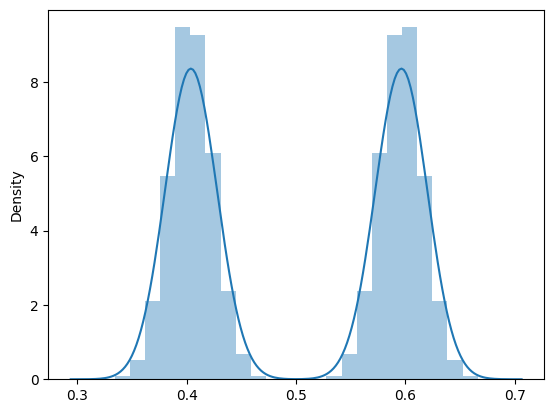

In [34]:
seaborn.distplot(k)